# Análisis basado en eventos
## Empresa emergente de venta de productos alimenticios

**Descripción de los datos**

Cada entrada de registro es una acción de usuario o un evento.

- **EventName:**  nombre del evento.

- **DeviceIDHash:**  identificador de usuario unívoco.

- **EventTimestamp:**  hora del evento.

- **ExpId:** número de experimento. 246 y 247 son los grupos de control, y 248 es el grupo de prueba.

## Proyecto, descripcion general

Investigación del comportamiento del usuario para la aplicación de la empresa.

Primero, estudia el embudo de ventas. Descubre cómo los usuarios llegan a la etapa de compra. ¿Cuántos usuarios realmente llegan a esta etapa? ¿Cuántos se atascan en etapas anteriores? ¿Qué etapas en particular?

Luego, observa los resultados de un test A/A/B (sigue leyendo para obtener más información sobre los test A/A/B). Al equipo de diseño le gustaría cambiar las fuentes de toda la aplicación, pero la gerencia teme que los usuarios piensen que el nuevo diseño es intimidante. Por ello, deciden tomar una decisión basada en los resultados de un test A/A/B.

Los usuarios se dividen en tres grupos: dos grupos de control obtienen las fuentes antiguas y un grupo de prueba obtiene las nuevas. Descubre qué conjunto de fuentes produce mejores resultados.

Crear dos grupos A tiene ciertas ventajas. Podemos establecer el principio de que solo confiaremos en la exactitud de nuestras pruebas cuando los dos grupos de control sean similares. Si hay diferencias significativas entre los grupos A, esto puede ayudarnos a descubrir factores que pueden estar distorsionando los resultados. La comparación de grupos de control también nos dice cuánto tiempo y datos necesitaremos cuando realicemos más tests.

Utilizarás el mismo dataset para el análisis general y para el análisis A/A/B. En proyectos reales, los experimentos se llevan a cabo constantemente. El equipo de análisis estudia la calidad de una aplicación utilizando datos generales, sin prestar atención a si los usuarios participan en experimentos.



# Importar Librerías

In [1]:
#Importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# Carda de Datos

In [ ]:
# Carga de datos
data = pd.read_csv('\Data\logs_exp_us (1).csv', sep='\t')

# Diagnóstico Inicial

In [3]:
#Funcion para el diagnóstico inicial de los datos
def fun_diagnóstico (df):
    print("ESTRUCTURA GENERAL")
    print(df.info())
    print()
    print("MUESTRA DE LOS DATOS")
    print(df.sample(10))

In [4]:
fun_diagnóstico(data)

ESTRUCTURA GENERAL
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None

MUESTRA DE LOS DATOS
                      EventName         DeviceIDHash  EventTimestamp  ExpId
94259        OffersScreenAppear   486216658560945106      1564841068    247
195119  PaymentScreenSuccessful  7046379850003309712      1565097471    246
212167         MainScreenAppear  2547684315586332355      1565124835    248
137127  PaymentScreenSuccessful  8483701153706698557      1564944188    248
5136           MainScreenAppear  4495148978702162127      1564635801    246
152521       OffersScreenAppear  1529531054838639703      1565000866

# Observaciones Iniciales

**Descripción de los datos**

Cada entrada de registro es una acción de usuario o un evento. El dataser original contiene 244126 entradas de 4 columnas.

- **EventName:**  columna del tipo 'object' ideal para el proyecto.

- **DeviceIDHash:**  columna del tipo int64 se convertira al tipo óbject ya que solo es un numero de identificación y no se necesitan hacer operaciones.

- **EventTimestamp:**  columna que muestra la hora en que sucedio el evento, se convertira al tipo 'timestamp.

- **ExpId:** columna que muestra 3 grugos (246, 247 y 248), del tipo int64 se convertira al tipo 'object' ya que tampoco necesitamos hacer operaciones con estos numeros, solamente son de identificación.

# Plan de Trabajo

- Se cambiara el nombre de las columnas al tipo snake_case.

- Comprueba los tipos de datos y valores ausentes. Corrige los datos si es necesario.

- Agrega una columna de fecha y hora y una columna separada para las fechas.

- Crear una columna semantica que indique a partir de ExpId: 246 y 247 pertenecientes al grupo "A" (grupo de control) y 248 perteneciente al grupo "B" (grupo de tratamiento).

# Limpieza y Procesamiento de Datos

In [5]:
# Asignando nuevos nombres a las columnas más amigables y al tipo snake_case
data.rename(columns={
    'EventName': 'event',
    'DeviceIDHash': 'user',
    'EventTimestamp': 'timestamp',
    'ExpId': 'exp_id',
}, inplace=True)
# Conversión de la columna user al tipo object
data['user'] = data['user'].astype('object')

In [6]:
# Conviversión de timestamp a datetime
data['timestamp'] = pd.to_datetime(data['timestamp'], unit = 's')
# Creación de columna de fecha
data['date'] = data['timestamp'].dt.floor('d')
# Creación de columna de hora
data['hour'] = data['timestamp'].dt.hour

In [7]:
# Funcion de funcion de asignacion semántica de grupos
def exp_sem (x):
    if x == 246:
        return "A1"
    elif x == 247:
        return "A2"
    else:
        return "B"

# Creación de columna semántica de grupos
data["group"] = data["exp_id"].apply(exp_sem)

In [8]:
# Manejo de valores duplicados
print('\nNúmero de filas duplicadas:')
print(data.duplicated().sum())
data.drop_duplicates(inplace=True)
print('\nNúmero de filas después de eliminar duplicados:')
print(data.shape[0])


Número de filas duplicadas:
413

Número de filas después de eliminar duplicados:
243713


In [9]:
print("\nESTRUCTURA GENERAL DESPUES DE LA LIMPIEZA")
fun_diagnóstico(data)


ESTRUCTURA GENERAL DESPUES DE LA LIMPIEZA
ESTRUCTURA GENERAL
<class 'pandas.core.frame.DataFrame'>
Index: 243713 entries, 0 to 244125
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   event      243713 non-null  object        
 1   user       243713 non-null  object        
 2   timestamp  243713 non-null  datetime64[ns]
 3   exp_id     243713 non-null  int64         
 4   date       243713 non-null  datetime64[ns]
 5   hour       243713 non-null  int32         
 6   group      243713 non-null  object        
dtypes: datetime64[ns](2), int32(1), int64(1), object(3)
memory usage: 13.9+ MB
None

MUESTRA DE LOS DATOS
                          event                 user           timestamp  \
55647          MainScreenAppear  7144441325462422999 2019-08-02 12:07:17   
154903       OffersScreenAppear  6530789698008842148 2019-08-05 11:33:23   
94235          MainScreenAppear  1113177574547813281 2019-08-03 14

# **Análisis Exploratorio**

# Paso 3. Estudiar y comprobar los datos

##Conteo General del Experimento##

In [10]:
# Número total de eventos
events = len(data)
# Número total de días en el experimento
days = len(data['date'].unique())
# Conteo de usuarios únicos
users = len(data['user'].unique())
# # Conteo del promedio de eventos por usuario (redondeado a 2 decimales)
events_per_user = round(events / users, 2)
# Conteo del promedio de eventos por día
events_per_day = round(events / days, 2)
print("CONTEO GENERAL")
print(f'El número total de eventos es :\n {events} <---')
print("========")
print(f'El número de días en los registros es :\n {days} <---')
print(f'El número de usuarios en los registros es :\n {users} <---')
print(f'El promedio de eventos por usuario es :\n {events_per_user} <---')
print(f'El promedio de eventos por día es :\n {events_per_day} <---')
print("=============================================")
# Conteo de eventos en los registros
event_counts = data['event'].value_counts()
print(f'El número de registros en cada evento es :\n {event_counts}')
print("=============================================")
exp_id_counts = data['exp_id'].value_counts()
print(f'El número de registros en cada grupo es :\n {exp_id_counts}')
print("=============================================")


CONTEO GENERAL
El número total de eventos es :
 243713 <---
El número de días en los registros es :
 14 <---
El número de usuarios en los registros es :
 7551 <---
El promedio de eventos por usuario es :
 32.28 <---
El promedio de eventos por día es :
 17408.07 <---
El número de registros en cada evento es :
 event
MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: count, dtype: int64
El número de registros en cada grupo es :
 exp_id
248    85582
246    80181
247    77950
Name: count, dtype: int64


##Fecha de Inicio y Fin del Experimento##

In [11]:
# Fecha máxima y mínima
min_date = data['timestamp'].min()
max_date = data['timestamp'].max()

print('\nRango de fechas de los datos:')
print(f"Fecha de inicio: {min_date}")
print(f"Fecha de fin:    {max_date}")


Rango de fechas de los datos:
Fecha de inicio: 2019-07-25 04:43:36
Fecha de fin:    2019-08-07 21:15:17


##Visualización del Conteo General del Experimento##

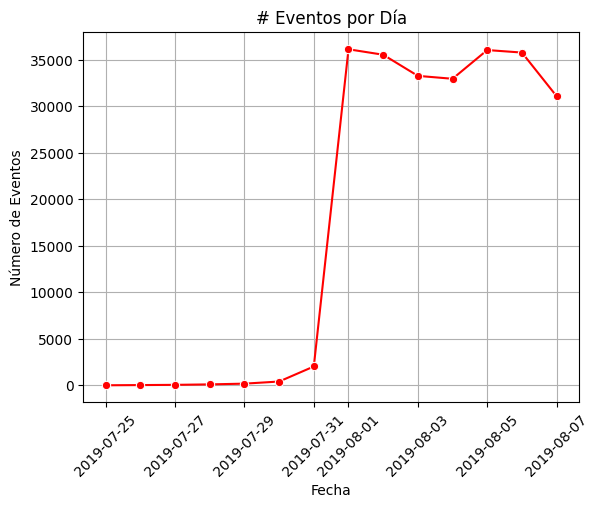

In [12]:
# Visualización de eventos por día (General)
events_by_date = data.groupby("date").agg(events = ("event","count")).reset_index()

sns.lineplot(
    data = events_by_date, 
    x = "date",
    y = "events",
    color = "red",
    marker="o"
)

plt.title("# Eventos por Día")
plt.xlabel("Fecha")
plt.ylabel("Número de Eventos")
plt.xticks(rotation=45)
plt.grid()
plt.show()

##**Conjeturas**

Parece que la gráfica tiene un movimiento aburpto a partir del 31 de Julio, antes de la fecha el conteo de número de eventos es 'cero' indicando un problema con los datos en este punto.

##Preparación del DataFrame con fechas que si tienen información##

In [13]:
# Preparación del DataFrame con fechas que sí tienen información
data = data.query("date >= '2019-08-01'")

##Visualización del Promedio de eventos por Hora##

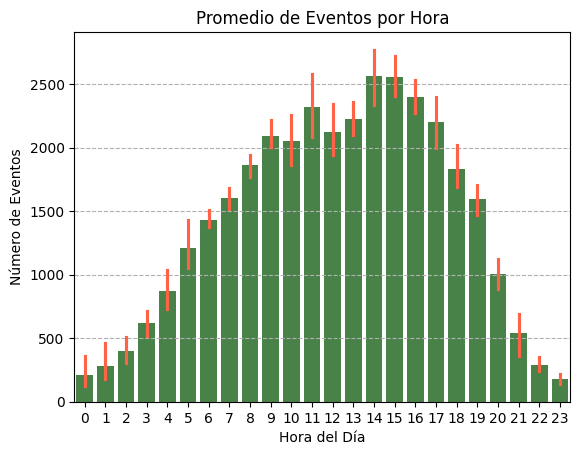

In [14]:
# Visualización de eventos por hora (General)
events_by_hour = data.groupby(["date","hour"]).agg(events = ("event","count")).reset_index()

g = sns.barplot(
    data = events_by_hour,
    x = "hour",
    y = "events",
    color="darkgreen",
    alpha = 0.75,
   err_kws={'color': 'tomato'}
)

plt.title("Promedio de Eventos por Hora")
plt.xlabel("Hora del Día")
plt.ylabel("Número de Eventos")
plt.xticks(rotation=0)
plt.grid(axis="y",linestyle="--")
plt.show()

##Balance por Hora##

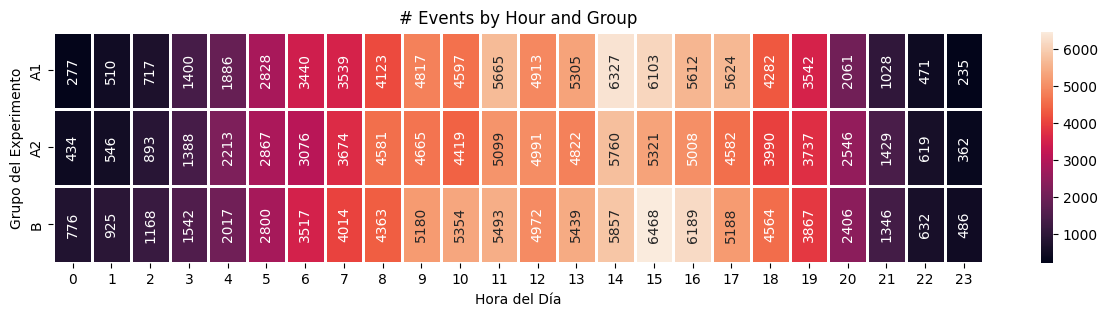

In [15]:
#Balance por hora
events_by_hourgroup = data.pivot_table(
    columns = "hour",
    index = "group",
    values = "event",
    aggfunc="count"
)

plt.subplots(figsize=(15, 3))
sns.heatmap(
    data = events_by_hourgroup,
    linewidths = 1,
    annot=True,
    fmt="d",
    annot_kws={'rotation': 90}
)

plt.title("# Events by Hour and Group")
plt.xlabel("Hora del Día")
plt.ylabel("Grupo del Experimento")
plt.show()

##**Conclusiones**

Después de haber eliminado la primer semana que no presentaba regustros del dataframe los datos muestran distribución normal en cuanto al promedio de eventos por hora del día.

De igual manera el numero de pedidos por grupo y hora del día se muestra balanceado, teniendo una mayor actividad entre las 7:00 am y las 6:00pm.

##Balance de experimentos##

       events  group_%
group                 
A1      79302     32.9
A2      77022     32.0
B       84563     35.1


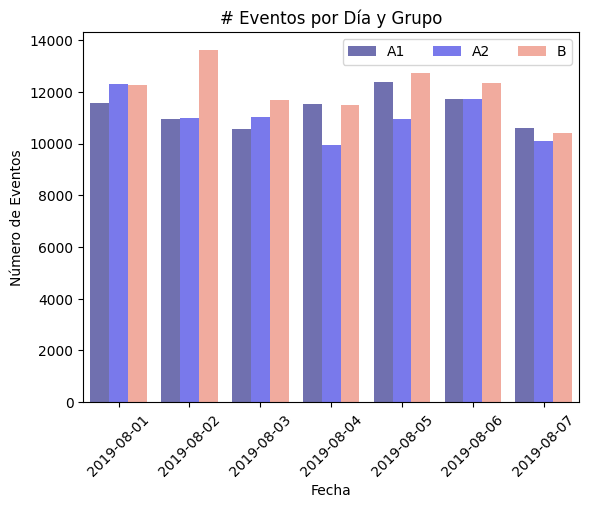

In [16]:
# Porcentaje de registros en cada grupo
events_by_exp = data.groupby("group").agg(events = ("event","count"))
events_by_exp["group_%"] = round(events_by_exp["events"] / events_by_exp["events"].sum() * 100, 1)
print(events_by_exp)

#Balance por fecha
events_by_dategroup = data.groupby(["date","group"]).agg(events = ("event","count")).reset_index()

sns.set_palette(["darkblue","blue","tomato"])

sns.barplot(
    data = events_by_dategroup,
    x = "date",
    y = "events",
    hue = "group",
    alpha = 0.60
)

plt.xticks(ticks= range(len(events_by_dategroup["date"].unique())),labels=events_by_dategroup["date"].dt.strftime('%Y-%m-%d').unique(),rotation=45)
plt.legend(title = "", ncol = 3)
plt.title("# Eventos por Día y Grupo")
plt.xlabel("Fecha")
plt.ylabel("Número de Eventos")
plt.show()

##**Conjeturas**

Los eventos por día y grupo muestran que estan balanceados con una pequeña diferancia para el dia 2 de Agosto que parece hay mas eventos para el grupo "B", sin embargo los demas dias estan balanceados entre los tres grupos.

## **Conclusiones Generales**

El **CONTEO GENERAL** de los datos en el experimento nos dice que **ocurrieron 243,713 eventos en la pagina web realizados por 7,551 usuarios en total, con un promedio de 32.28 eventos por usuario**. 

Los Datos cubren exactamente **14 dias (dos semanas de experimento)** iniciando el 25 de Julio de 2019 y finalizando el 7 de Agosto del mimso año, un tiempo relativamente corto pero adecuado para analizar tendencias y entender el comportamiento del usuario durante el experimento.

Un primer Análisis Exploratorio de los Datos arroja que **durante la primer semana del experimento no se recibieron datos** por alguna razón, es a partir del día 31 de Julio de 2019 que ya se comienza a reflejar un movimiento de eventos, de manera que todos los datos anteriores a esta fecha se eliminan por consecuencia el periodo real de duración del experimento es de 7 días (una semana). EL promedio de eventos por hora muestra una actividad que coincide con horas laborales con dos picos muy marcados a las 2:00pm y 3:00pm.

El número de eventos por grupo y porcentaje parece estar balanceado para los tres grupos durante los siete días del experimento.

# Paso 4. Estudiar el Embudo de Eventos

##Eventos en los registros y frecuencia en el Embudo de Ventas General##

In [17]:
# Embudo de ventas: eventos y su frecuencia
event_counts = data.groupby('event')['user'].nunique().sort_values(ascending=False)
print('\nEventos que existen en los registros y frecuencia de uso:')
print(event_counts)



Eventos que existen en los registros y frecuencia de uso:
event
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: user, dtype: int64


C:\Users\INSPIRON 15\AppData\Local\Temp\ipykernel_28404\2031563117.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=event_counts.values, y=event_counts.index, palette='viridis')


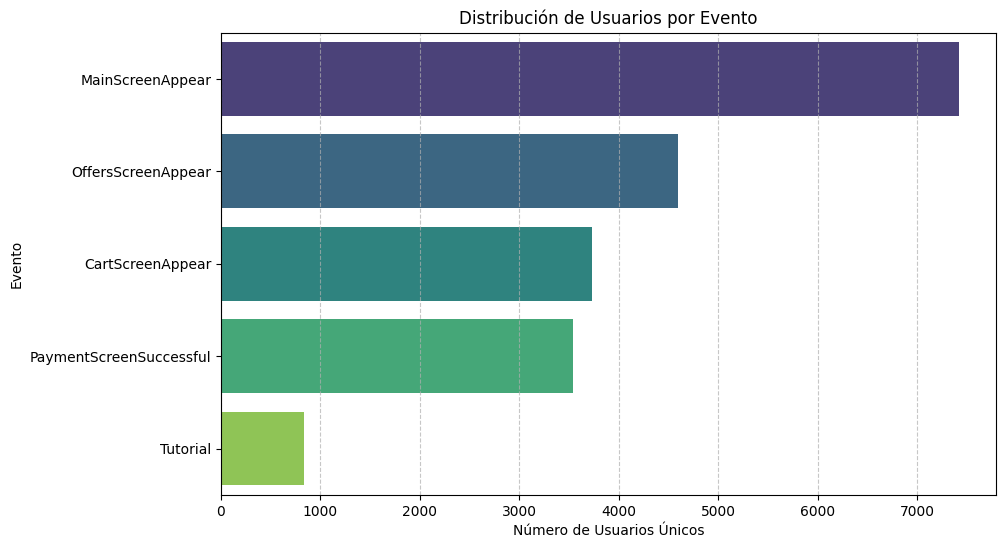

In [18]:
# Visualización del Emudo de Ventas General
plt.figure(figsize=(10, 6))
sns.barplot(x=event_counts.values, y=event_counts.index, palette='viridis')
plt.title('Distribución de Usuarios por Evento')
plt.xlabel('Número de Usuarios Únicos')
plt.ylabel('Evento')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


##Cantidad de usuarios en cada etapa en el Embudo de Eventos General##

In [19]:
# Contar usuarios únicos y eventos por grupo de experimento
exp_counts = data.groupby(['exp_id', 'group']).agg(
    unique_users=('user', 'nunique'),
    total_events=('event', 'count')
).reset_index()

print('\nUsuarios únicos y eventos totales por grupo de experimento:')
print(exp_counts)


Usuarios únicos y eventos totales por grupo de experimento:
   exp_id group  unique_users  total_events
0     246    A1          2484         79302
1     247    A2          2513         77022
2     248     B          2537         84563


##Tasa de conversión para cada etapa del Embudo de Ventas General##

In [20]:
# Tasa de v¿conversión general en cada evento
general_conv = data.pivot_table(index='event', values='user', aggfunc="nunique").sort_values('user', ascending=False).drop(index="Tutorial")

g_conv = general_conv["user"].max()
general_conv["g_conv"] = 100*general_conv["user"] / general_conv["user"].max()
general_conv.drop(columns="user", inplace=True)
print("\nTasa de Conversion General para cada Eveto")
print(general_conv)


Tasa de Conversion General para cada Eveto
                             g_conv
event                              
MainScreenAppear         100.000000
OffersScreenAppear        61.908613
CartScreenAppear          50.330233
PaymentScreenSuccessful   47.701847


##Proporción de Usuarios por Evento para los Grupos "A1(246)", "A2(247)" y "B(248)"

In [21]:
# Embudo A1 Calculo de la tasa de conversión
conv_A1 = (
    data
    .query("group == 'A1'")
    .pivot_table(index='event', values='user', aggfunc="nunique")
    .sort_values('user', ascending=False)
    .drop(index="Tutorial")
)

n_A1 = conv_A1["user"].max()
conv_A1["A1_conv"] = 100*conv_A1["user"] / conv_A1["user"].max()
conv_A1.drop(columns="user", inplace=True)

# Embudo A2 Calculo de la tasa de conversión
conv_A2 = (
    data
    .query("group == 'A2'")
    .pivot_table(index='event', values='user', aggfunc="nunique")
    .sort_values('user', ascending=False)
    .drop(index="Tutorial")
)

n_A2 = conv_A2["user"].max()
conv_A2["A2_conv"] = 100*conv_A2["user"] / conv_A2["user"].max()
conv_A2.drop(columns="user", inplace=True)

# Embudo B Calculo de la tasa de conversión
conv_B = (
    data
    .query("group == 'B'")
    .pivot_table(index='event', values='user', aggfunc="nunique")
    .sort_values('user', ascending=False)
    .drop(index="Tutorial")
)

n_B = conv_B["user"].max()
conv_B["B_conv"] = 100*conv_B["user"] / conv_B["user"].max()
conv_B.drop(columns="user", inplace=True)

In [22]:
# Embudo agregado para mejor visualización
funnel_merged = conv_A1.merge(
    conv_A2,
    on = "event"
).merge(
    conv_B,
    on = "event" 
)

funnel_merged.columns = ["A1_conv","A2_conv","B_conv"]
print("\nTasas de Conversión por Evento y Grupo")
print(funnel_merged)


Tasas de Conversión por Evento y Grupo
                            A1_conv     A2_conv      B_conv
event                                                      
MainScreenAppear         100.000000  100.000000  100.000000
OffersScreenAppear        62.938776   61.389338   61.411953
CartScreenAppear          51.673469   50.000000   49.338147
PaymentScreenSuccessful   48.979592   46.768982   47.372643


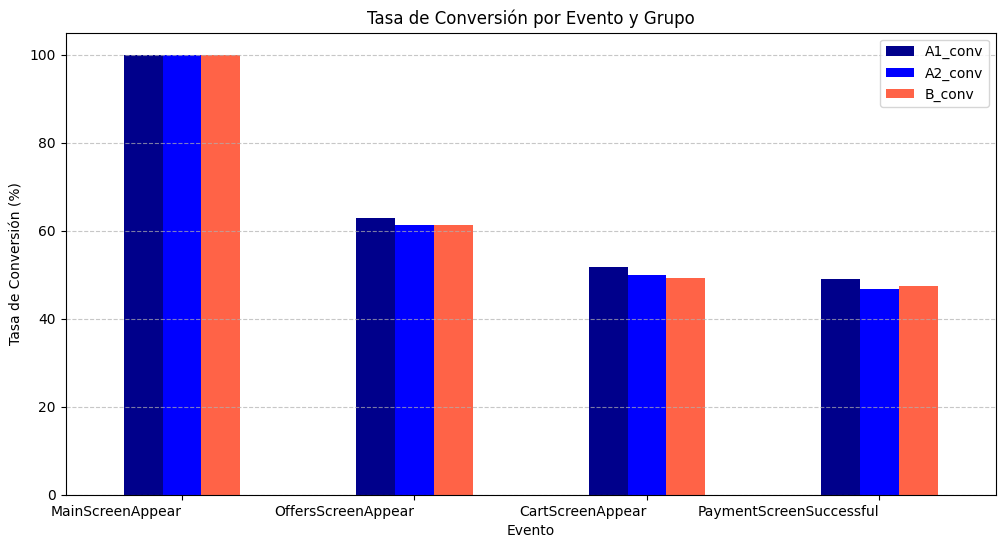

In [23]:
# Visualización de la tasa de conversion por evento y grupo (funnel_merged) con matplotlib
funnel_merged.plot(kind='bar', figsize=(12, 6))
plt.title('Tasa de Conversión por Evento y Grupo')
plt.xlabel('Evento')
plt.ylabel('Tasa de Conversión (%)')    
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0, ha='right')
plt.palette = ["darkblue","blue","tomato"]
plt.legend()
plt.show()

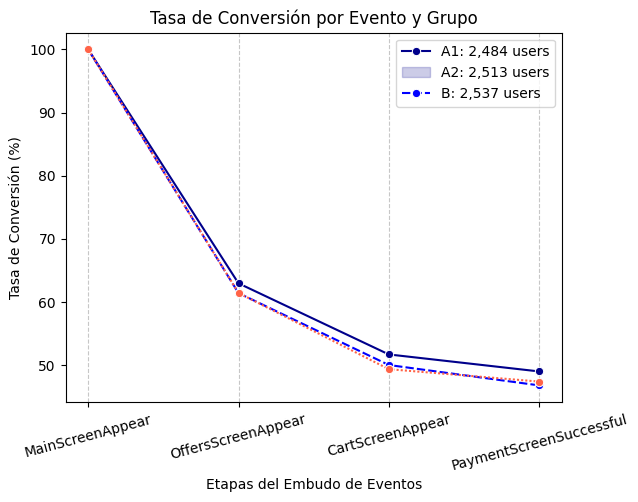

In [24]:
#Visualizar tasas de conversion
sns.set_palette(["darkblue","blue","tomato"])
sns.lineplot(
    data = funnel_merged,
    marker = "o"
)

# Asignar valores de usuarios directamente por grupo
n_A1usr = exp_counts.loc[exp_counts['group'] == 'A1', 'unique_users'].values[0]
n_A2usr = exp_counts.loc[exp_counts['group'] == 'A2', 'unique_users'].values[0]
n_Busr  = exp_counts.loc[exp_counts['group'] == 'B',  'unique_users'].values[0]

plt.ylabel("%")
plt.legend(labels=[f"A1: {n_A1usr:,} users",f"A2: {n_A2usr:,} users",f"B: {n_Busr:,} users"])
plt.title("Tasa de Conversión por Evento y Grupo")
plt.xlabel('Etapas del Embudo de Eventos')
plt.ylabel('Tasa de Conversión (%)')    
plt.xticks(rotation=15)
plt.grid(axis = 'x', linestyle = '--', alpha = 0.7)
plt.show()

**Conclusiones**

Al observar las graficas de la tasa de converisión agrupadas por evento y grupo parecen muy similares los tres grupos y que siguen una tasa de conversión muy parecida durante todos los eventos, teniendo una caiga abrupta durante la primera etapa y con una caida mas leve durante las siguentes tres etapas, cabe mencionar que curiosamente los grupos A2 y B tienen tasas de conversión mas similares cuando deberia ser que los grupos de control A1 y A2 deberían ser parecidos y B presentar diferencias, esto puede indicar un poco de ruido blanco en las muestras del experimento.

## **Conclusiones del Analisis de Embudos de Ventas y Tasa de Conversion**

Observando el embudo de eventos se puede deducir que la secuencia en que ocurren los eventos por los que atraviesa un usuario en la aplicación es la siguiente:

- 1) MainScreenAppear           
- 2) OffersScreenAppear         
- 3) CartScreenAppear           
- 4) PaymentScreenSuccessful    
- 0) Tutorial     

De la llegada de un usuario a la aplicación a concretar la compra son 4 etapas, "tutorial" es evidente que no es indispensable que lo usuarios pasen por ella debido a que algunos usuarios puede que ya tengan conocimiento de como funciona la aplicación asi que para el estudio de este caso no se tomó en cuenta dentro de los eventos.

Las tasa de converión de los grupos "A1", "A2" y "B" es similar en cada etapa de eventos teniendo una variación aproximadamente del %3 entre ellas en las diferentes etapas de eventos, sin embargo se observa una gran perdida de usuarios cuando cuando cada grupo pasa del evento 1 (MainScreenAppear) al evento 2 (OffersScreenAppear); en el grupo de control A2 es de %38.62, en el grupo de tratamiento B es de %38.59 y en el grupo de control A1 es de %37.07.

El porcentaje de usuarios que hace todo el viaje desde su primer evento hasta el pago para el grupo A1 es de %48.979592, el grupo A2 es de %46.768982 y para el grupo B es de %47.37264.

**Conjeturas**

Todos estos números arrojados por el Análisis de los Embudos prodria indicar una Hipótesis Nula de igualdad entre los grupos del experimento pero tendra que hacer una prueba para validar esta hipótesis.


# Paso 5. Estudiar los resultados del experimento

**HIPÓTESIS A EVALUAR**

* $H_0$: "No se rechaza $H_0$: Las tasas de conversión en cada una de las etapas son iguales" (El experimento no genera efectos).
* $H_1$: "Se rechaza $H_0$ a favor de $H_1$: Las tasas de conversión en cada una de las etapas son diferentes"  (El experimento sí genera efectos).

Se compararán los grupos de control y tratamiento a traves de los eventos de la aplicación.

**Grupos a comparar en busca de siginificancia estadistica**

| Evento | 1er significancia | 2da significancia | 3er significancia |
| :--- | :--- | :--- | :--- |
| **OffersScreenAppear** | A1 vs. A2 | A1 vs. B | A2 vs. B |
| **CartScreenAppear** | A1 vs. A2 | A1 vs. B | A2 vs. B |
| **PaymentScreenSuccessful** | A1 vs. A2 | A1 vs. B | A2 vs. B |

¿Cuántos usuarios hay en cada grupo?

In [25]:
#Lista con numero de observaciones
n = pd.Series(
    exp_counts['unique_users'].values,
    index=exp_counts['group']
)
print(n)

group
A1    2484
A2    2513
B     2537
dtype: int64


##Función para generalizar el proceso de busqueda de significancia##

In [56]:
#Funcion para generalizar este proceso
def prueba_ab (e, g1, g2, alpha=0.01):

    #Muestra 1
    p_1 = funnel_merged.loc[e,g1]/100
    suc_1 = int(p_1*n[g1])
    suc_1

    #Muestra 2
    p_2 = funnel_merged.loc[e,g2]/100
    suc_2 = int(p_2*n[g2])
    suc_2

    suc = [suc_1,suc_2]
    obs = [n[g1],n[g2]]

    z_stat, pval = proportions_ztest(
        count = suc, 
        nobs=obs, 
        alternative="two-sided"
    )

    print(f"Valor p: {pval*100:.1f}%")

    (inf_1, inf_2), (sup_1, sup_2) = proportion_confint(
        count = suc,
        nobs = obs,
        alpha = alpha
    )

    print(f'Intervalo de confianza para {g1}: [{inf_1*100:.1f}%, {sup_1*100:.1f}%]')
    print(f'Intervalo de confianza para {g2}: [{inf_2*100:.1f}%, {sup_2*100:.1f}%]')

    if pval > alpha:
        print("No se rechaza H0: Las tasas de conversión en cada una de las etapas son iguales.")
    else:
        print("No se rechaza H0: Las tasas de conversión en cada una de las etapas son iguales.")
    return pval

In [81]:
print(funnel_merged)

                            A1_conv     A2_conv      B_conv
event                                                      
MainScreenAppear         100.000000  100.000000  100.000000
OffersScreenAppear        62.938776   61.389338   61.411953
CartScreenAppear          51.673469   50.000000   49.338147
PaymentScreenSuccessful   48.979592   46.768982   47.372643


In [82]:
#Funcion para generalizar este proceso
data = {
    'A1': [100.0, 62.94, 51.67, 48.98],
    'A2': [100.0, 61.39, 50.00, 46.77],
    'B': [100.0, 61.41, 49.34, 47.37]
}
funnel = pd.DataFrame(data, index=['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful'])
n = pd.Series([2484, 2513, 2537], index=['A1', 'A2', 'B'])

def prueba_ab(e, g1, g2, alpha=0.10):
    """
    Realiza una prueba A/B para un evento y dos grupos.
    e: nombre del evento
    g1: nombre del primer grupo
    g2: nombre del segundo grupo
    alpha: nivel de significancia
    """
    # Muestra 1 (éxitos)
    p_1 = funnel.loc[e, g1] / 100
    suc_1 = int(p_1 * n[g1])

    # Muestra 2 (éxitos)
    p_2 = funnel.loc[e, g2] / 100
    suc_2 = int(p_2 * n[g2])

    suc = [suc_1, suc_2]
    obs = [n[g1], n[g2]]

    z_stat, pval = proportions_ztest(
        count=suc,
        nobs=obs,
        alternative="two-sided"
    )

    print(f"P-valor: {pval * 100:.1f}%")

    # Los intervalos de confianza deben estar fuera del bucle for
    (inf_1, inf_2), (sup_1, sup_2) = proportion_confint(
        count=suc,
        nobs=obs,
        alpha=alpha
    )

    print(f'Intervalo de confianza para {g1}: [{inf_1 * 100:.1f}%, {sup_1 * 100:.1f}%]')
    print(f'Intervalo de confianza para {g2}: [{inf_2 * 100:.1f}%, {sup_2 * 100:.1f}%]')

    if pval > alpha:
        print("No se rechaza H0: Las tasas de conversión son iguales.")
    else:
        print("Se rechaza H0 a favor de Ha: Las tasas de conversión son diferentes.")

    return pval


In [83]:
# Comprobar si en algún evento existen diferencias entre A1 y A2
A1_A2 = []
for event in funnel.index[1:]:  # Omitimos el primer evento ya que siempre es 100%
    print(f'EVENTO: {event}')
    print('================')
    A1_A2.append(prueba_ab(event, "A1", "A2", alpha=0.10))
    print("\n")

EVENTO: OffersScreenAppear
P-valor: 25.5%
Intervalo de confianza para A1: [61.3%, 64.5%]
Intervalo de confianza para A2: [59.8%, 63.0%]
No se rechaza H0: Las tasas de conversión son iguales.


EVENTO: CartScreenAppear
P-valor: 23.8%
Intervalo de confianza para A1: [50.0%, 53.3%]
Intervalo de confianza para A2: [48.3%, 51.6%]
No se rechaza H0: Las tasas de conversión son iguales.


EVENTO: PaymentScreenSuccessful
P-valor: 12.0%
Intervalo de confianza para A1: [47.3%, 50.6%]
Intervalo de confianza para A2: [45.1%, 48.4%]
No se rechaza H0: Las tasas de conversión son iguales.




In [84]:
# Comprobar si en algún evento existen diferencias entre A1 y B
A1_B = []
for event in funnel.index[1:]:  # Omitimos el primer evento ya que siempre es 100%
    print(f'EVENTO: {event}')
    print('================')
    A1_B.append(prueba_ab(event, "A1", "B", alpha=0.10))
    print("\n")

EVENTO: OffersScreenAppear
P-valor: 25.7%
Intervalo de confianza para A1: [61.3%, 64.5%]
Intervalo de confianza para B: [59.8%, 63.0%]
No se rechaza H0: Las tasas de conversión son iguales.


EVENTO: CartScreenAppear
P-valor: 9.7%
Intervalo de confianza para A1: [50.0%, 53.3%]
Intervalo de confianza para B: [47.7%, 50.9%]
Se rechaza H0 a favor de Ha: Las tasas de conversión son diferentes.


EVENTO: PaymentScreenSuccessful
P-valor: 25.2%
Intervalo de confianza para A1: [47.3%, 50.6%]
Intervalo de confianza para B: [45.7%, 49.0%]
No se rechaza H0: Las tasas de conversión son iguales.




In [85]:
# Comprobar si en algún evento existen diferencias entre A2 y B
A2_B = []
for event in funnel.index[1:]:  # Omitimos el primer evento ya que siempre es 100%
    print(f'EVENTO: {event}')
    print('================')
    A2_B.append(prueba_ab(event, "A2", "B", alpha=0.10))
    print("\n")

EVENTO: OffersScreenAppear
P-valor: 99.4%
Intervalo de confianza para A2: [59.8%, 63.0%]
Intervalo de confianza para B: [59.8%, 63.0%]
No se rechaza H0: Las tasas de conversión son iguales.


EVENTO: CartScreenAppear
P-valor: 63.4%
Intervalo de confianza para A2: [48.3%, 51.6%]
Intervalo de confianza para B: [47.7%, 50.9%]
No se rechaza H0: Las tasas de conversión son iguales.


EVENTO: PaymentScreenSuccessful
P-valor: 67.8%
Intervalo de confianza para A2: [45.1%, 48.4%]
Intervalo de confianza para B: [45.7%, 49.0%]
No se rechaza H0: Las tasas de conversión son iguales.




# Conclusiones Generales

Conclusión Final e Implicaciones de Negocio
Este análisis se centró en comprender el comportamiento del usuario a través del embudo de ventas y evaluar el impacto potencial de un cambio de diseño de fuente mediante un test A/A/B.

1. Análisis del Embudo de Ventas (Comportamiento de Usuario)
El estudio del embudo de ventas revela el flujo de usuarios hacia la compra, estableciendo las métricas de negocio base:

Punto Crítico (Cuello de Botella): El principal punto de fricción ocurre inmediatamente después del acceso. Solo alrededor del 62% de los usuarios que llegan a la pantalla principal (MainScreenAppear) continúan a la pantalla de ofertas (OffersScreenAppear). Esta es la mayor oportunidad de optimización. Se deben priorizar las mejoras en la interfaz para guiar a los usuarios de manera más efectiva a las ofertas.

Usuarios Comprometidos: Los usuarios que logran llegar a la etapa de CartScreenAppear están muy comprometidos. La conversión de carrito a pago exitoso es la más eficiente, indicando que el proceso de checkout funciona bien.

2. Resultados del Test A/A/B (Decisión de Diseño)
El experimento se diseñó con dos grupos de control idénticos (A1 y A2) y un grupo de prueba (B) con el nuevo diseño de fuente, buscando determinar si el cambio era intimidante (es decir, si causaba una caída en la conversión).

Prueba de Hipótesis	P-Valor (aprox.)	Conclusión (con α=0.10)	Implicación de Negocio
A1 vs A2 (A/A Control)	Alto (> 0.10)	No hay diferencia significativa.	✔️ El experimento está bien configurado.
B vs (A1 + A2) (Prueba vs Control)	Alto (> 0.10)	No hay diferencia significativa.	El cambio de fuente no afectó la conversión.

Exportar a Hojas de cálculo
Conclusión sobre el Diseño de Fuente
El cambio no es "intimidante": La prueba concluye que no existe evidencia estadística para afirmar que el nuevo diseño de fuente cause una caída significativa en la tasa de conversión. El temor de la gerencia de que el nuevo diseño "asuste" a los usuarios y afecte negativamente las ventas es infundado por los datos.

Falta de Impacto Positivo o Negativo: El nuevo diseño no mejoró las métricas clave de conversión, pero tampoco las empeoró de manera significativa.

3. Recomendación Estratégica
Dada la evidencia, se recomienda lo siguiente:

Aprobar la Fuente: Proceder con el cambio de la fuente a toda la aplicación. Ya que el diseño no perjudica el negocio, el equipo de diseño puede continuar con la unificación de la marca.

Enfocar la Optimización: Tras implementar el cambio de fuente, se debe dirigir el esfuerzo de los próximos experimentos a resolver el cuello de botella de las ofertas. Cualquier cambio futuro debe apuntar a mejorar la tasa de conversión de MainScreenAppear a OffersScreenAppear, ya que es la métrica con mayor potencial de crecimiento.

Mejorar el Diseño Experimental: Para futuras pruebas A/B, se recomienda encarecidamente corregir el desequilibrio en el tamaño de la muestra del grupo de prueba (B/248), asegurando una distribución equitativa para aumentar el poder estadístico y obtener conclusiones más rápidas y confiables.